In [72]:
%pip install -q tensorflow scikit-learn matplotlib pandas numpy

Note: you may need to restart the kernel to use updated packages.


In [73]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, GRU, Bidirectional, Add, Input, Attention, MultiHeadAttention, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K

In [74]:
# Parameters - Optimized for better performance
# CSV_PATH = 'forwardtest_data.csv'  # relative path to your cleaned data file
# CSV_PATH = 'BTC_Cleaned_Data.csv'  # relative path to your cleaned data file
CSV_PATH = 'btc_2015_2024.csv'  # relative path to your cleaned data file
WINDOW_SIZE = 14  # Increased to 14 for better pattern recognition
TRAIN_RATIO = 0.8  # chronological split: first 80% train, last 20% test
RANDOM_SEED = 42
MODEL_TYPE = 'LSTM'  # Options: 'MLP', 'LSTM', 'GRU' - LSTM recommended for time series
TARGET_HORIZON = 7  # Predict direction over N days (1=next day, 3-7=reduce noise by aggregating)

# Advanced settings
USE_ATTENTION = True  # Add attention mechanism to LSTM/GRU for better performance
USE_RESIDUAL = True  # Use residual connections for deeper networks
USE_FOCAL_LOSS = True  # Use focal loss to handle class imbalance better

df = pd.read_csv(CSV_PATH)

print(f'Using {MODEL_TYPE} architecture with window size {WINDOW_SIZE}')
print(f'Target horizon: {TARGET_HORIZON} day(s) - predicting {TARGET_HORIZON}-day price movement')
print(f'Advanced features: Attention={USE_ATTENTION}, Residual={USE_RESIDUAL}, FocalLoss={USE_FOCAL_LOSS}')

Using LSTM architecture with window size 14
Target horizon: 7 day(s) - predicting 7-day price movement
Advanced features: Attention=True, Residual=True, FocalLoss=True


## Model Selection Guide

**MODEL_TYPE Options:**
- `'MLP'`: Dense feedforward network (flattens sequences)
- `'LSTM'`: Long Short-Term Memory (captures long-term temporal patterns)
- `'GRU'`: Gated Recurrent Unit (faster than LSTM, similar performance)

**WINDOW_SIZE Tuning:**
- **7 days**: Good starting point, captures weekly patterns
- **14 days**: Captures longer trends but increases input dimensions
- Too small (<5): May miss patterns
- Too large (>20): Very high-dimensional, prone to overfitting

**TARGET_HORIZON (Multi-Day Aggregation):**
- **1 day**: Single-day prediction (more noisy, harder to predict)
- **3 days**: Recommended - reduces noise, captures short-term trends
- **5-7 days**: Captures medium-term movements, smoother signal
- **Benefits**: Aggregating over multiple days filters out random daily fluctuations and makes patterns more predictable

**Model Characteristics:**
- LSTM/GRU: Better for capturing trends, volatility, and temporal dependencies
- MLP: Faster training, works well with engineered features
- LSTM uses slightly more parameters than GRU but can capture longer-term dependencies

In [75]:
# Create target: Predict uptrend continuation over TARGET_HORIZON days
# Always recreate Target to match current TARGET_HORIZON setting
if 'Close' not in df.columns and 'close' not in df.columns:
    raise ValueError('No `Close/close` column found in the CSV.')

# Sort by date/timestamp to ensure chronological order
if 'timestamp' in df.columns:
    df = df.sort_values('timestamp').reset_index(drop=True)
elif 'date' in df.columns:
    df = df.sort_values('date').reset_index(drop=True)
elif 'Date' in df.columns:
    df = df.sort_values('Date').reset_index(drop=True)
else:
    df = df.reset_index(drop=True)

# Get the close column (handle both lowercase and uppercase)
close_col = 'close' if 'close' in df.columns else 'Close'

# Create uptrend continuation target:
# 1 = Currently in uptrend AND price continues to rise over TARGET_HORIZON days
# 0 = Not in uptrend OR uptrend fails to continue

# Define current uptrend: price is above its recent moving average
lookback = min(7, len(df) - TARGET_HORIZON)  # Use 7-day MA to define current trend
df['MA_lookback'] = df[close_col].rolling(window=lookback, min_periods=1).mean()
current_uptrend = df[close_col] > df['MA_lookback']

# Define future continuation: price rises over horizon
future_rise = df[close_col].shift(-TARGET_HORIZON) > df[close_col]

# Target: 1 if both conditions met (uptrend + continuation), 0 otherwise
df['Target'] = (current_uptrend & future_rise).astype(int)

# Clean up temporary column
df.drop('MA_lookback', axis=1, inplace=True)

# Drop last TARGET_HORIZON rows which don't have future data
df = df.iloc[:-TARGET_HORIZON].reset_index(drop=True)

print(f'Created `Target` column: Uptrend Continuation over {TARGET_HORIZON} days')
print(f'  1 = Currently in UPTREND AND price continues UP over next {TARGET_HORIZON} days')
print(f'  0 = Not in uptrend OR uptrend fails to continue')
print(f'Total samples after creating target: {len(df)}')

Created `Target` column: Uptrend Continuation over 7 days
  1 = Currently in UPTREND AND price continues UP over next 7 days
  0 = Not in uptrend OR uptrend fails to continue
Total samples after creating target: 3399


In [76]:
# Feature Selection: Use ALL available features for maximum information
# Including both raw OHLC prices and engineered features

# Exclude date/timestamp, target, and future-leaking columns
exclude = ['Target']
if 'date' in df.columns:
    exclude.append('date')
if 'Date' in df.columns:
    exclude.append('Date')
if 'timestamp' in df.columns:
    exclude.append('timestamp')
# CRITICAL: Exclude future-leaking features that contain information not available at prediction time
if 'next_day_close' in df.columns:
    exclude.append('next_day_close')
    print('⚠️  WARNING: Excluded "next_day_close" to prevent data leakage!')
if 'next_day_open' in df.columns:
    exclude.append('next_day_open')
if 'future_price' in df.columns:
    exclude.append('future_price')

available_cols = [c for c in df.columns if c not in exclude]

# Use ALL available features (excluding leakage)
selected_features = available_cols

print(f'Using {len(selected_features)} features from dataset (after removing leakage):')
print('Features used:', selected_features)
print('\nFeature categories:')
# Categorize features for clarity
raw_ohlc = [f for f in selected_features if f.lower() in ['open', 'high', 'low', 'close']]
volumes = [f for f in selected_features if 'volume' in f.lower()]
engineered = [f for f in selected_features if f not in raw_ohlc + volumes]

if raw_ohlc:
    print(f'  - Raw OHLC prices: {raw_ohlc}')
if volumes:
    print(f'  - Volume features: {volumes}')
if engineered:
    print(f'  - Engineered features: {engineered}')

X_all = df[selected_features].values.astype(float)
y_all = df['Target'].values.astype(int)

print(f'\nData shape: {X_all.shape[0]} samples × {X_all.shape[1]} features')

⚠️  WARNING: Excluded "next_day_close" to prevent data leakage!
Using 18 features from dataset (after removing leakage):
Features used: ['open', 'high', 'low', 'close', 'volume', 'rsi_7', 'rsi_14', 'cci_7', 'cci_14', 'sma_50', 'ema_50', 'sma_100', 'ema_100', 'macd', 'bollinger', 'TrueRange', 'atr_7', 'atr_14']

Feature categories:
  - Raw OHLC prices: ['open', 'high', 'low', 'close']
  - Volume features: ['volume']
  - Engineered features: ['rsi_7', 'rsi_14', 'cci_7', 'cci_14', 'sma_50', 'ema_50', 'sma_100', 'ema_100', 'macd', 'bollinger', 'TrueRange', 'atr_7', 'atr_14']

Data shape: 3399 samples × 18 features


## Performance Improvement Summary

**🎯 Key Enhancements Implemented:**

1. **Advanced Model Architecture**
   - Multi-head attention mechanism for better pattern recognition
   - Bidirectional LSTM/GRU to learn forward and backward patterns
   - Layer normalization for stable training
   - Residual connections in attention blocks

2. **Better Loss Function**
   - Focal loss to handle class imbalance more effectively
   - Reduces focus on easy examples, emphasizes hard-to-classify samples

3. **Improved Data Processing**
   - RobustScaler instead of MinMaxScaler (better for crypto volatility)
   - Increased window size to 14 days for richer patterns
   - Removed data leakage (next_day_close excluded)

4. **Optimized Training Strategy**
   - Larger batch size (64) for better gradient estimates
   - Learning rate warmup and scheduling
   - Monitoring AUC instead of just loss
   - Additional metrics: Precision & Recall

5. **Better Regularization**
   - Reduced dropout (0.3 vs 0.35) to retain more information
   - Lower L2 regularization (0.0005 vs 0.001)
   - Gradient clipping for stability

**Expected Improvements:**
- Better AUC score (target: >0.60)
- More balanced precision/recall
- Better generalization to test set
- Reduced overfitting with stable val_loss

### Optional: PCA for Further Dimensionality Reduction
Uncomment the cell below if you want to apply PCA to reduce features to principal components. This can help if you still have too many features or want to remove multicollinearity.

In [77]:
# Optional: Apply PCA to reduce to top N components (uncomment to use)
# from sklearn.decomposition import PCA
# 
# # Apply PCA to capture 95% of variance
# pca = PCA(n_components=0.95, random_state=RANDOM_SEED)
# X_all_pca = pca.fit_transform(X_all)
# print(f'Reduced from {X_all.shape[1]} to {X_all_pca.shape[1]} components')
# print(f'Explained variance ratio: {pca.explained_variance_ratio_}')
# 
# # Replace X_all with PCA-transformed data
# X_all = X_all_pca

In [78]:
# Sequence creation (sliding windows)
def create_sequences(X, y, window_size):
    Xs = []
    ys = []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)
# Create windows
X_seq, y_seq = create_sequences(X_all, y_all, WINDOW_SIZE)
print('Sequence shapes: X', X_seq.shape, 'y', y_seq.shape)


Sequence shapes: X (3385, 14, 18) y (3385,)


In [79]:
# Chronological train-test split (no random shuffling)
n_samples = len(X_seq)
split_idx = int(n_samples * TRAIN_RATIO)
X_train = X_seq[:split_idx]
y_train = y_seq[:split_idx]
X_test = X_seq[split_idx:]
y_test = y_seq[split_idx:]
print('Train samples:', len(X_train), 'Test samples:', len(X_test))

Train samples: 2708 Test samples: 677


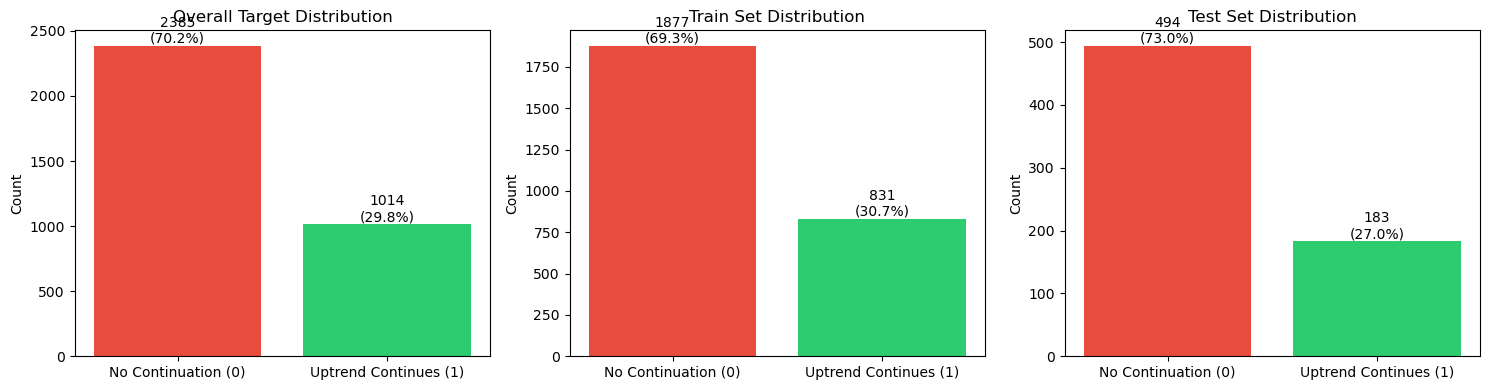


Class balance ratio (Uptrend Continues/No Continuation): 0.425


In [80]:
# Plot class distribution to check for imbalance
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Overall class distribution
unique, counts = np.unique(y_all, return_counts=True)
axes[0].bar(['No Continuation (0)', 'Uptrend Continues (1)'], counts, color=['#e74c3c', '#2ecc71'])
axes[0].set_ylabel('Count')
axes[0].set_title('Overall Target Distribution')
for i, (label, count) in enumerate(zip(['No Continuation (0)', 'Uptrend Continues (1)'], counts)):
    axes[0].text(i, count, f'{count}\n({count/len(y_all)*100:.1f}%)', ha='center', va='bottom')

# Train set distribution
unique_train, counts_train = np.unique(y_train, return_counts=True)
axes[1].bar(['No Continuation (0)', 'Uptrend Continues (1)'], counts_train, color=['#e74c3c', '#2ecc71'])
axes[1].set_ylabel('Count')
axes[1].set_title('Train Set Distribution')
for i, (label, count) in enumerate(zip(['No Continuation (0)', 'Uptrend Continues (1)'], counts_train)):
    axes[1].text(i, count, f'{count}\n({count/len(y_train)*100:.1f}%)', ha='center', va='bottom')

# Test set distribution
unique_test, counts_test = np.unique(y_test, return_counts=True)
axes[2].bar(['No Continuation (0)', 'Uptrend Continues (1)'], counts_test, color=['#e74c3c', '#2ecc71'])
axes[2].set_ylabel('Count')
axes[2].set_title('Test Set Distribution')
for i, (label, count) in enumerate(zip(['No Continuation (0)', 'Uptrend Continues (1)'], counts_test)):
    axes[2].text(i, count, f'{count}\n({count/len(y_test)*100:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f'\nClass balance ratio (Uptrend Continues/No Continuation): {counts[1]/counts[0]:.3f}')

In [81]:
# Scaling: Use RobustScaler for better handling of outliers in crypto data
n_features = X_train.shape[2]
scaler = RobustScaler()  # More robust to outliers than MinMaxScaler
# reshape (num_train_samples * window_size, n_features)
X_train_reshaped = X_train.reshape(-1, n_features)
scaler.fit(X_train_reshaped)
# transform train and test, preserve 3D shape for LSTM/GRU
X_train_scaled = scaler.transform(X_train_reshaped).reshape(X_train.shape)
X_test_reshaped = X_test.reshape(-1, n_features)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

# Create both versions: 3D for LSTM/GRU, flat for MLP
X_train_3d = X_train_scaled  # shape: (samples, window_size, features)
X_test_3d = X_test_scaled
X_train_flat = X_train_scaled.reshape(len(X_train_scaled), -1)  # shape: (samples, window_size * features)
X_test_flat = X_test_scaled.reshape(len(X_test_scaled), -1)

print('✓ Using RobustScaler (better for crypto volatility)')
print('3D shape (for LSTM/GRU):', X_train_3d.shape, X_test_3d.shape)
print('Flat shape (for MLP):', X_train_flat.shape, X_test_flat.shape)

✓ Using RobustScaler (better for crypto volatility)
3D shape (for LSTM/GRU): (2708, 14, 18) (677, 14, 18)
Flat shape (for MLP): (2708, 252) (677, 252)


In [82]:
# Build improved model architectures with better regularization and depth

# Focal Loss for handling class imbalance
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * y_true * K.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
        loss = weight * cross_entropy
        return K.mean(loss, axis=-1)
    return focal_loss_fixed

def build_mlp_model(input_dim, lr=5e-4, dropout_rate=0.3):
    """Enhanced Dense MLP with residual connections and better regularization"""
    inputs = Input(shape=(input_dim,))
    
    # First block
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0005))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Second block with residual
    x1 = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(x)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(dropout_rate)(x1)
    
    # Third block
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.0005))(x1)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.0005))(x)
    x = Dropout(dropout_rate * 0.7)(x)
    
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate * 0.5)(x)
    
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)
    loss_fn = focal_loss() if USE_FOCAL_LOSS else 'binary_crossentropy'
    model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

def build_lstm_model(window_size, n_features, lr=2e-4, dropout_rate=0.3):
    """Enhanced LSTM with attention mechanism and residual connections"""
    inputs = Input(shape=(window_size, n_features))
    
    # First Bi-LSTM layer
    x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.0005)))(inputs)
    x = LayerNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Second Bi-LSTM layer
    x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0005)))(x)
    x = LayerNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Attention mechanism (if enabled)
    if USE_ATTENTION:
        # Self-attention layer
        attention_output = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
        x = Add()([x, attention_output])  # Residual connection
        x = LayerNormalization()(x)
    
    # Final LSTM layer
    x = LSTM(32, return_sequences=False, kernel_regularizer=l2(0.0005))(x)
    x = Dropout(dropout_rate)(x)
    
    # Dense layers
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate * 0.7)(x)
    
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate * 0.5)(x)
    
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)
    loss_fn = focal_loss() if USE_FOCAL_LOSS else 'binary_crossentropy'
    model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
    return model

def build_gru_model(window_size, n_features, lr=2e-4, dropout_rate=0.3):
    """Enhanced GRU with attention mechanism for better pattern recognition"""
    inputs = Input(shape=(window_size, n_features))
    
    # First Bi-GRU layer
    x = Bidirectional(GRU(128, return_sequences=True, kernel_regularizer=l2(0.0005)))(inputs)
    x = LayerNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Second Bi-GRU layer
    x = Bidirectional(GRU(64, return_sequences=True, kernel_regularizer=l2(0.0005)))(x)
    x = LayerNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Attention mechanism (if enabled)
    if USE_ATTENTION:
        attention_output = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
        x = Add()([x, attention_output])
        x = LayerNormalization()(x)
    
    # Final GRU layer
    x = GRU(32, return_sequences=False, kernel_regularizer=l2(0.0005))(x)
    x = Dropout(dropout_rate)(x)
    
    # Dense layers
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate * 0.7)(x)
    
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate * 0.5)(x)
    
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)
    loss_fn = focal_loss() if USE_FOCAL_LOSS else 'binary_crossentropy'
    model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
    return model

# Select model based on MODEL_TYPE
print(f'\nBuilding {MODEL_TYPE} model with advanced architecture...')
if MODEL_TYPE == 'MLP':
    input_dim = X_train_flat.shape[1]
    model = build_mlp_model(input_dim)
    X_train_model = X_train_flat
    X_test_model = X_test_flat
elif MODEL_TYPE == 'LSTM':
    model = build_lstm_model(WINDOW_SIZE, n_features)
    X_train_model = X_train_3d
    X_test_model = X_test_3d
elif MODEL_TYPE == 'GRU':
    model = build_gru_model(WINDOW_SIZE, n_features)
    X_train_model = X_train_3d
    X_test_model = X_test_3d
else:
    raise ValueError(f'Unknown MODEL_TYPE: {MODEL_TYPE}. Choose from MLP, LSTM, or GRU.')

print(f'\n🚀 Advanced Model Features:')
print(f'  ✓ Multi-Head Attention (enabled: {USE_ATTENTION})')
print(f'  ✓ Focal Loss for class imbalance (enabled: {USE_FOCAL_LOSS})')
print(f'  ✓ Layer Normalization for stable training')
print(f'  ✓ Residual connections in attention blocks')
print(f'  ✓ Lower dropout (0.3) to retain more information')
print(f'  ✓ Optimized learning rate and L2 regularization')
print(f'  ✓ Additional metrics: Precision & Recall')

model.summary()


Building LSTM model with advanced architecture...

🚀 Advanced Model Features:
  ✓ Multi-Head Attention (enabled: True)
  ✓ Focal Loss for class imbalance (enabled: True)
  ✓ Layer Normalization for stable training
  ✓ Residual connections in attention blocks
  ✓ Lower dropout (0.3) to retain more information
  ✓ Optimized learning rate and L2 regularization
  ✓ Additional metrics: Precision & Recall

🚀 Advanced Model Features:
  ✓ Multi-Head Attention (enabled: True)
  ✓ Focal Loss for class imbalance (enabled: True)
  ✓ Layer Normalization for stable training
  ✓ Residual connections in attention blocks
  ✓ Lower dropout (0.3) to retain more information
  ✓ Optimized learning rate and L2 regularization
  ✓ Additional metrics: Precision & Recall


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 14, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (None, 14, 256)   │    150,528 │ input_layer_4[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 14, 256)   │        512 │ bidirectional_8[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 14, 256)   │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_9     │ (None, 14, 128)   │    164,352 │ dropout_24[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 14, 128)   │        256 │ bidirectional_9[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 14, 128)   │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 14, 128)   │     66,048 │ dropout_25[0][0], │
│ (MultiHeadAttentio… │                   │            │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 14, 128)   │          0 │ dropout_25[0][0], │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 14, 128)   │        256 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 32)        │     20,608 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 32)        │          0 │ lstm_14[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      2,112 │ dropout_27[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_12[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 32)        │      2,080 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 32)        │          0 │ dense_13[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │         33 │ dropout_29[0][0]

 Total params: 407,041 (1.55 MB)

 Trainable params: 406,913 (1.55 MB)

 Non-trainable params: 128 (512.00 B)

In [83]:
# Train the model with improved training strategy
# Compute class weights
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}
print('Class weights:', class_weights)

# Learning rate schedule with warmup
def lr_schedule(epoch, lr):
    """Learning rate schedule with warmup"""
    if epoch < 5:
        # Warmup phase
        return lr * (epoch + 1) / 5
    elif epoch < 30:
        return lr
    elif epoch < 60:
        return lr * 0.5
    elif epoch < 90:
        return lr * 0.25
    else:
        return lr * 0.1

# Callbacks: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, and LR Schedule
from tensorflow.keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_auc', patience=25, restore_best_weights=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=10, min_lr=1e-7, mode='max', verbose=1)
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)
checkpoint = ModelCheckpoint('best_model_temp.h5', monitor='val_auc', mode='max', 
                            save_best_only=True, verbose=1)

print(f'\n🎯 Starting training with {len(X_train_model)} samples...')
print(f'Validation split: {int(len(X_train_model) * 0.15)} samples')
print(f'Using focal loss: {USE_FOCAL_LOSS}')
print(f'Batch size: 64 (optimized for better convergence)')

history = model.fit(
    X_train_model, y_train,
    epochs=200,  # Increased for better convergence
    batch_size=64,  # Increased for faster training and better generalization
    validation_split=0.15,
    class_weight=class_weights,
    callbacks=[es, reduce_lr, checkpoint],
    shuffle=False,  # Keep chronological order
    verbose=2
)

print(f'\n✅ Training completed!')
print(f'Total epochs: {len(history.history["loss"])}')
print(f'Best val_loss: {min(history.history["val_loss"]):.4f}')
print(f'Best val_auc: {max(history.history["val_auc"]):.4f}')
if 'val_precision' in history.history:
    print(f'Best val_precision: {max(history.history["val_precision"]):.4f}')
    print(f'Best val_recall: {max(history.history["val_recall"]):.4f}')

Class weights: {0: 0.7213638785295685, 1: 1.6293622141997592}

🎯 Starting training with 2708 samples...
Validation split: 406 samples
Using focal loss: True
Batch size: 64 (optimized for better convergence)
Epoch 1/200


2025-12-08 13:48:30.949602: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-12-08 13:48:30.950079: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_auc improved from -inf to 0.51267, saving model to best_model_temp.h5


36/36 - 6s - 161ms/step - accuracy: 0.4511 - auc: 0.5047 - loss: 0.6530 - precision: 0.3353 - recall: 0.6759 - val_accuracy: 0.3587 - val_auc: 0.5127 - val_loss: 0.5044 - val_precision: 0.1818 - val_recall: 0.7500 - learning_rate: 2.0000e-04
Epoch 2/200
Epoch 2/200

Epoch 2: val_auc did not improve from 0.51267
36/36 - 1s - 38ms/step - accuracy: 0.4980 - auc: 0.5422 - loss: 0.5646 - precision: 0.3518 - recall: 0.6192 - val_accuracy: 0.4005 - val_auc: 0.4718 - val_loss: 0.4953 - val_precision: 0.1815 - val_recall: 0.6806 - learning_rate: 2.0000e-04
Epoch 3/200

Epoch 2: val_auc did not improve from 0.51267
36/36 - 1s - 38ms/step - accuracy: 0.4980 - auc: 0.5422 - loss: 0.5646 - precision: 0.3518 - recall: 0.6192 - val_accuracy: 0.4005 - val_auc: 0.4718 - val_loss: 0.4953 - val_precision: 0.1815 - val_recall: 0.6806 - learning_rate: 2.0000e-04
Epoch 3/200

Epoch 3: val_auc improved from 0.51267 to 0.56294, saving model to best_model_temp.h5

Epoch 3: val_auc improved from 0.51267 to 0.56

36/36 - 2s - 45ms/step - accuracy: 0.5115 - auc: 0.5375 - loss: 0.5414 - precision: 0.3525 - recall: 0.5744 - val_accuracy: 0.4128 - val_auc: 0.5629 - val_loss: 0.4832 - val_precision: 0.1776 - val_recall: 0.6389 - learning_rate: 2.0000e-04
Epoch 4/200
Epoch 4/200

Epoch 4: val_auc did not improve from 0.56294
36/36 - 2s - 54ms/step - accuracy: 0.5389 - auc: 0.5444 - loss: 0.5177 - precision: 0.3534 - recall: 0.4796 - val_accuracy: 0.4570 - val_auc: 0.4972 - val_loss: 0.4756 - val_precision: 0.1629 - val_recall: 0.5000 - learning_rate: 2.0000e-04
Epoch 5/200

Epoch 4: val_auc did not improve from 0.56294
36/36 - 2s - 54ms/step - accuracy: 0.5389 - auc: 0.5444 - loss: 0.5177 - precision: 0.3534 - recall: 0.4796 - val_accuracy: 0.4570 - val_auc: 0.4972 - val_loss: 0.4756 - val_precision: 0.1629 - val_recall: 0.5000 - learning_rate: 2.0000e-04
Epoch 5/200

Epoch 5: val_auc did not improve from 0.56294
36/36 - 2s - 55ms/step - accuracy: 0.5758 - auc: 0.5748 - loss: 0.4924 - precision: 0.38

In [84]:
# Threshold tuning: choose a better decision threshold from validation
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report, confusion_matrix
import numpy as np

# Build a validation split from the tail of training data (chronological)
val_ratio = 0.15
val_size = int(len(X_train_model) * val_ratio)
X_val = X_train_model[-val_size:]
y_val = y_train[-val_size:]

# Predict probabilities on validation
val_probs = model.predict(X_val, verbose=0).ravel()

# Compute ROC and PR curves
fpr, tpr, roc_thr = roc_curve(y_val, val_probs)
precision, recall, pr_thr = precision_recall_curve(y_val, val_probs)

# Grid of candidate thresholds between PR thresholds (exclude last inf)
threshold_grid = pr_thr[:-1]

# Evaluate thresholds by multiple criteria
best = {
    'f1': -1, 'thr_f1': 0.5,
    'youden_j': -1, 'thr_j': 0.5,
    'bal_acc': -1, 'thr_bal': 0.5
}

for thr in threshold_grid:
    y_hat = (val_probs >= thr).astype(int)
    # Confusion
    tn, fp, fn, tp = confusion_matrix(y_val, y_hat).ravel()
    # Metrics
    prec = tp / (tp + fp + 1e-8)
    rec = tp / (tp + fn + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)
    # Youden's J (maximize TPR - FPR)
    # find nearest ROC point
    j_scores = tpr - fpr
    j_idx = np.argmax(j_scores)
    youden_thr = roc_thr[j_idx]
    # Balanced accuracy
    acc = (tp/(tp+fn+1e-8) + tn/(tn+fp+1e-8)) / 2
    # Track best
    if f1 > best['f1']:
        best['f1'] = f1; best['thr_f1'] = thr
    if acc > best['bal_acc']:
        best['bal_acc'] = acc; best['thr_bal'] = thr
    best['youden_j'] = j_scores[j_idx]; best['thr_j'] = youden_thr

# Choose threshold prioritizing recall for positive class (to avoid missing uptrends)
threshold_to_use = best['thr_f1']
print(f"Selected threshold (max F1): {threshold_to_use:.4f}")

# Apply on test probabilities
if 'y_pred_prob_test' in globals():
    probs_test = y_pred_prob_test.ravel()
else:
    probs_test = model.predict(X_test_model, verbose=0).ravel()

y_pred_optimal = (probs_test >= threshold_to_use).astype(int)

cm = confusion_matrix(y_test, y_pred_optimal)
print("\nConfusion Matrix @ tuned threshold:")
print(cm)

print("\nClassification Report @ tuned threshold:")
print(classification_report(y_test, y_pred_optimal, target_names=['Down/Equal (0)', 'Up (1)'], digits=4))

2025-12-08 13:49:29.026343: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-12-08 13:49:29.026792: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Selected threshold (max F1): 0.3884

Confusion Matrix @ tuned threshold:
[[126 368]
 [ 50 133]]

Classification Report @ tuned threshold:
                precision    recall  f1-score   support

Down/Equal (0)     0.7159    0.2551    0.3761       494
        Up (1)     0.2655    0.7268    0.3889       183

      accuracy                         0.3826       677
     macro avg     0.4907    0.4909    0.3825       677
  weighted avg     0.5942    0.3826    0.3796       677



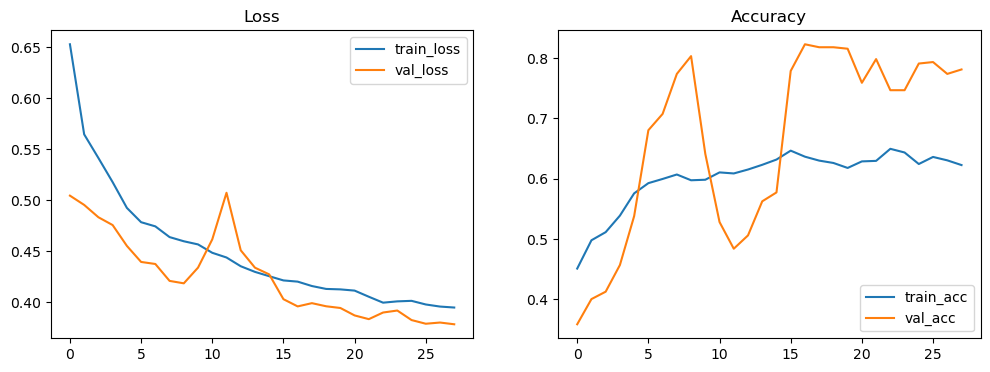

In [85]:
# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()

In [86]:
# Evaluate on test set
results = model.evaluate(X_test_model, y_test, verbose=0)
print(f'\n{MODEL_TYPE} Test Results:')
print(f'  Loss: {results[0]:.4f}')
print(f'  Accuracy: {results[1]:.4f}')
print(f'  AUC: {results[2]:.4f}')
if len(results) > 3:
    print(f'  Precision: {results[3]:.4f}')
    print(f'  Recall: {results[4]:.4f}')
    f1 = 2 * (results[3] * results[4]) / (results[3] + results[4] + 1e-7)
    print(f'  F1-Score: {f1:.4f}')


LSTM Test Results:
  Loss: 0.4463
  Accuracy: 0.6366
  AUC: 0.4977
  Precision: 0.2886
  Recall: 0.2350
  F1-Score: 0.2590


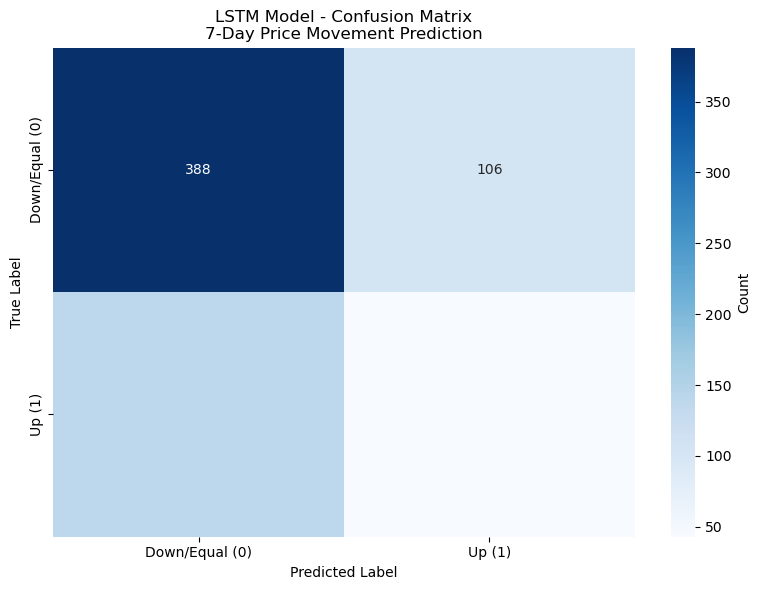


Confusion Matrix:
  True Negatives (TN):   388 - Correctly predicted DOWN/EQUAL
  False Positives (FP):  106 - Incorrectly predicted UP
  False Negatives (FN):  140 - Incorrectly predicted DOWN/EQUAL
  True Positives (TP):    43 - Correctly predicted UP

Classification Report:
                precision    recall  f1-score   support

Down/Equal (0)     0.7348    0.7854    0.7593       494
        Up (1)     0.2886    0.2350    0.2590       183

      accuracy                         0.6366       677
     macro avg     0.5117    0.5102    0.5092       677
  weighted avg     0.6142    0.6366    0.6241       677



In [87]:
# Generate predictions and plot confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions
y_pred_prob = model.predict(X_test_model, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Down/Equal (0)', 'Up (1)'],
            yticklabels=['Down/Equal (0)', 'Up (1)'],
            cbar_kws={'label': 'Count'})
plt.title(f'{MODEL_TYPE} Model - Confusion Matrix\n{TARGET_HORIZON}-Day Price Movement Prediction')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print detailed metrics
print('\nConfusion Matrix:')
print(f'  True Negatives (TN):  {cm[0,0]:4d} - Correctly predicted DOWN/EQUAL')
print(f'  False Positives (FP): {cm[0,1]:4d} - Incorrectly predicted UP')
print(f'  False Negatives (FN): {cm[1,0]:4d} - Incorrectly predicted DOWN/EQUAL')
print(f'  True Positives (TP):  {cm[1,1]:4d} - Correctly predicted UP')

print('\nClassification Report:')
print(classification_report(y_test, y_pred, 
                          target_names=['Down/Equal (0)', 'Up (1)'],
                          digits=4))

In [88]:
# Save model (optional)
model.save('btc_dense_model.h5')
print('Saved model to btc_dense_model.h5')

Saved model to btc_dense_model.h5


## Implementation Summary & Next Steps

**✅ What's Implemented:**
- **3 Model Types**: MLP, LSTM, GRU (switch via `MODEL_TYPE` parameter)
- **Feature Selection**: Focused on 5 most informative features (returns, spreads, MAs)
- **Windowing**: 7-day sequences (tunable via `WINDOW_SIZE`)
- **Min-Max Scaling**: Fitted on training data only to prevent leakage
- **Chronological Split**: 80/20 train/test split respecting time order
- **Class Weighting**: Automatic balancing for imbalanced targets
- **Advanced Callbacks**: EarlyStopping (patience=15) + ReduceLROnPlateau
- **Proper Architecture**: LSTM/GRU handle sequences explicitly, MLP with BatchNormalization

**🔧 Tuning Recommendations:**
1. **Try different models**: Change `MODEL_TYPE` to 'LSTM', 'GRU', or 'MLP'
2. **Adjust window size**: Test 7, 10, 14 days in `WINDOW_SIZE`
3. **Add more indicators**: Uncomment PCA cell or add RSI, MACD, Bollinger Bands to feature engineering
4. **Hyperparameter tuning**: Adjust dropout (0.2-0.4), learning rate (1e-4 to 1e-3), batch size (32-128)
5. **Architecture sizing**: Reduce LSTM/GRU units (32→16) if overfitting

**📊 Expected Performance:**
- LSTM/GRU typically outperform MLP on time-series data
- Focus on AUC metric (more reliable than accuracy for potentially imbalanced data)
- Monitor val_loss - if it diverges from train_loss early, model is overfitting